# Analytics - Camada SILVER | Sinistros PRF 2024-2025

Os dados analisados neste *notebook* são consumidos diretamente da **Base de Dados PostgreSQL** (contentor `sbd2-prf`), orquestrada via Docker. Esta camada armazena o resultado persistido do processo de ETL (*Extract, Transform, Load*), garantindo o acesso a dados estruturados e relacionais.

## Descrição da Infraestrutura e Dados

A tabela consultada (`silver.sinistros`) representa a versão higienizada dos acidentes, armazenada no serviço de banco de dados definido na nossa infraestrutura:

* **Fonte de Dados:** PostgreSQL (Serviço: `postgres` | Porta: `5432`).
* **Origem:** Dados processados a partir dos ficheiros CSV da camada Bronze.

Para detalhes sobre o significado das colunas, consulte o [dicionário de dados](../raw/dicionario_de_dados.pdf).

## Análise Exploratória dos Dados Validados

Nesta secção, estabelecemos a conexão com a instância Docker para extrair o *dataset* tratado. O foco é validar a qualidade do carregamento e gerar estatísticas descritivas sobre os sinistros.


**Principais diferenças em relação à camada RAW:**
- Dados limpos e normalizados
- Outliers removidos (idades > 120 anos)
- Valores "Ignorado" convertidos para NULL
- Coordenadas validadas (-90 a 90 lat, -180 a 180 lon)
- Faixas etárias padronizadas (0-9, 10-19, ..., 100+)
- Deduplicação por chave primária (sinistro_id, pessoa_id)

## 1. Configuração e Conexão com Banco de Dados

In [1]:
from pathlib import Path
from dotenv import load_dotenv
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

import psycopg2
from psycopg2.extras import RealDictCursor

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('Set2')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 11

BASE_PATH = Path(os.getcwd()).parent.parent
load_dotenv(BASE_PATH / ".env")

DB_CONFIG = {
    "host": os.getenv("DB_HOST"),
    "port": os.getenv("DB_PORT"),
    "database": os.getenv("POSTGRES_DB"),
    "user": os.getenv("POSTGRES_USER"),
    "password": os.getenv("POSTGRES_PASSWORD"),
}

print(f"Conectando ao banco: {DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}")

Conectando ao banco: 127.0.0.1:5433/prf


## 2. Carregamento dos Dados SILVER

In [2]:
def load_silver_data():
    conn = psycopg2.connect(**DB_CONFIG)
    
    query = "SELECT * FROM silver.sinistros;"
    
    df = pd.read_sql(query, conn)
    conn.close()
    
    return df

df = load_silver_data()
print(f'Dataset SILVER carregado: {len(df):,} registros | {len(df.columns)} colunas')
print(f'Chaves únicas (sinistro_id, pessoa_id): {df[["sinistro_id", "pessoa_id"]].drop_duplicates().shape[0]:,}')

Dataset SILVER carregado: 339,183 registros | 25 colunas
Chaves únicas (sinistro_id, pessoa_id): 339,183


## 3. Visão Geral dos Dados SILVER

In [3]:
df.head(10)

,ano_arquivo,sinistro_id,pessoa_id,veiculo_id,data_hora,dia_semana_num,uf,municipio,delegacia,latitude,...,condicao_meteorologica,tipo_pista,tracado_via,caracteristicas_via,tipo_envolvido,estado_fisico,faixa_etaria,sexo,tipo_veiculo,faixa_idade_veiculo
0,2024,571772,1268971,1018215.0,2024-01-01 00:05:00,0,RJ,TANGUA,DEL02-RJ,-22.729360,...,Céu Claro,Dupla,Reta,urbano,Condutor,obito,20-29,Masculino,Motocicleta,0-4
1,2024,571774,1268985,1018226.0,2024-01-01 00:05:00,0,GO,ANAPOLIS,DEL02-GO,-16.229185,...,Céu Claro,Dupla,Reta,rural,Condutor,ileso,30-39,Feminino,Automóvel,15-19
2,2024,571777,1269020,1018251.0,2024-01-01 01:45:00,0,ES,SERRA,DEL02-ES,-20.172928,...,Nublado,Múltipla,Interseção de Vias;Reta,urbano,Condutor,ileso,50-59,Masculino,Caminhonete,15-19
3,2024,571778,1269028,1018261.0,2024-01-01 00:45:00,0,SC,PENHA,DEL03-SC,-26.834770,...,Chuva,Dupla,Curva,rural,Condutor,ileso,50-59,Masculino,Camioneta,10-14
4,2024,571778,1269045,1018261.0,2024-01-01 00:45:00,0,SC,PENHA,DEL03-SC,-26.834770,...,Chuva,Dupla,Curva,rural,Passageiro,leve,30-39,Feminino,Camioneta,10-14
5,2024,571779,1268976,1018219.0,2024-01-01 01:45:00,0,RS,NOVO HAMBURGO,DEL01-RS,-29.669385,...,Céu Claro,Dupla,Reta,urbano,Condutor,ileso,40-49,Masculino,Automóvel,10-14
6,2024,571779,1268998,1018219.0,2024-01-01 01:45:00,0,RS,NOVO HAMBURGO,DEL01-RS,-29.669385,...,Céu Claro,Dupla,Reta,urbano,Passageiro,ileso,0-9,Feminino,Automóvel,10-14
7,2024,571779,1268999,1018219.0,2024-01-01 01:45:00,0,RS,NOVO HAMBURGO,DEL01-RS,-29.669385,...,Céu Claro,Dupla,Reta,urbano,Passageiro,ileso,0-9,Masculino,Automóvel,10-14
8,2024,571779,1269000,1018219.0,2024-01-01 01:45:00,0,RS,NOVO HAMBURGO,DEL01-RS,-29.669385,...,Céu Claro,Dupla,Reta,urbano,Passageiro,ileso,10-19,Feminino,Automóvel,10-14
9,2024,571780,1268977,1018220.0,2024-01-01 01:50:00,0,PR,SAO JOSE DOS PINHAIS,DEL01-PR,-25.541123,...,Céu Claro,Simples,Curva,rural,Condutor,leve,40-49,Masculino,Motocicleta,15-19


## 4. Informações do Dataset

In [4]:
print(f"Registros: {len(df):,} | Colunas: {len(df.columns)} | Período: 2024-2025 | Memória: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
df.info()

Registros: 339,183 | Colunas: 25 | Período: 2024-2025 | Memória: 355.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339183 entries, 0 to 339182
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   ano_arquivo             339183 non-null  int64         
 1   sinistro_id             339183 non-null  int64         
 2   pessoa_id               339183 non-null  int64         
 3   veiculo_id              326844 non-null  float64       
 4   data_hora               339183 non-null  datetime64[ns]
 5   dia_semana_num          339183 non-null  int64         
 6   uf                      339183 non-null  object        
 7   municipio               339183 non-null  object        
 8   delegacia               339035 non-null  object        
 9   latitude                339183 non-null  float64       
 10  longitude               339183 non-null  float64       
 11  causa_acidente   

## 5. Qualidade dos Dados - Comparação RAW vs SILVER

**Melhorias aplicadas na camada SILVER:**
- ✅ Outliers de idade removidos (idade > 120)
- ✅ Coordenadas validadas e normalizadas
- ✅ Valores "Ignorado" convertidos para NULL
- ✅ Registros duplicados removidos
- ✅ Registros sem chave primária removidos

In [5]:
print("QUALIDADE DOS DADOS - SILVER")
print("="*80)

print(f"\nRegistros sem sinistro_id: {df['sinistro_id'].isna().sum()} (0 esperado)")
print(f"Registros sem pessoa_id: {df['pessoa_id'].isna().sum()} (0 esperado)")
print(f"Duplicatas por (sinistro_id, pessoa_id): {df.duplicated(subset=['sinistro_id', 'pessoa_id']).sum()} (0 esperado)")

print(f"\nFaixas etárias NULL: {df['faixa_etaria_condutor'].isna().sum():,}")
print(f"Coordenadas inválidas (lat/lon fora do range): {((df['latitude'] < -90) | (df['latitude'] > 90)).sum()}")

print(f"\nCondicao meteorológica 'ignorado': {df['condicao_meteorologica'].fillna('').str.lower().str.contains('ignorado').sum()} (0 esperado - convertidos para NULL)")

print("="*80)

QUALIDADE DOS DADOS - SILVER

Registros sem sinistro_id: 0 (0 esperado)
Registros sem pessoa_id: 0 (0 esperado)
Duplicatas por (sinistro_id, pessoa_id): 0 (0 esperado)


KeyError: 'faixa_etaria_condutor'

## ANÁLISE 1: Evolução Temporal (2024-2025)

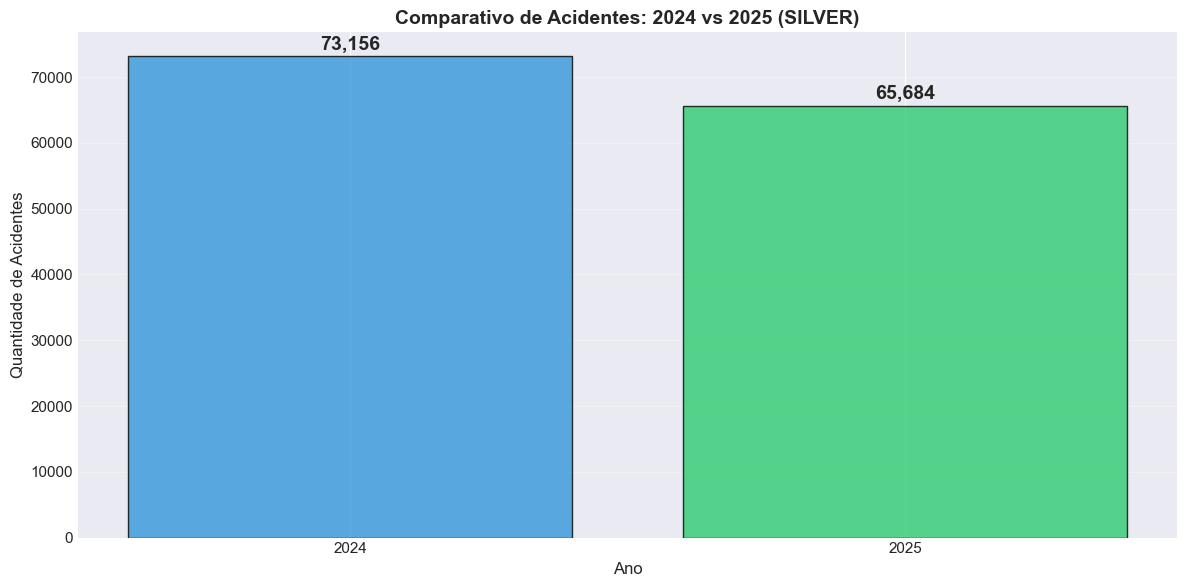

2024: 73,156 | 2025: 65,684 | Variação: -10.2%


In [ ]:
acidentes_ano = df.groupby('ano_arquivo')['sinistro_id'].nunique().sort_index()

fig, ax = plt.subplots(figsize=(12, 6))
cores = ['#3498db', '#2ecc71']
bars = ax.bar(acidentes_ano.index.astype(str), acidentes_ano.values, 
              color=cores, alpha=0.8, edgecolor='black')

for i, (ano, valor) in enumerate(acidentes_ano.items()):
    ax.text(i, valor + 1000, f'{valor:,}', ha='center', fontweight='bold', fontsize=14)

ax.set_title('Comparativo de Acidentes: 2024 vs 2025 (SILVER)', fontsize=14, fontweight='bold')
ax.set_xlabel('Ano', fontsize=12)
ax.set_ylabel('Quantidade de Acidentes', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

if 2024 in acidentes_ano.index and 2025 in acidentes_ano.index:
    acidentes_2024 = acidentes_ano[2024]
    acidentes_2025 = acidentes_ano[2025]
    variacao = ((acidentes_2025 - acidentes_2024) / acidentes_2024) * 100
    print(f"2024: {acidentes_2024:,} | 2025: {acidentes_2025:,} | Variação: {variacao:+.1f}%")

## ANÁLISE 1.1: Evolução Mensal

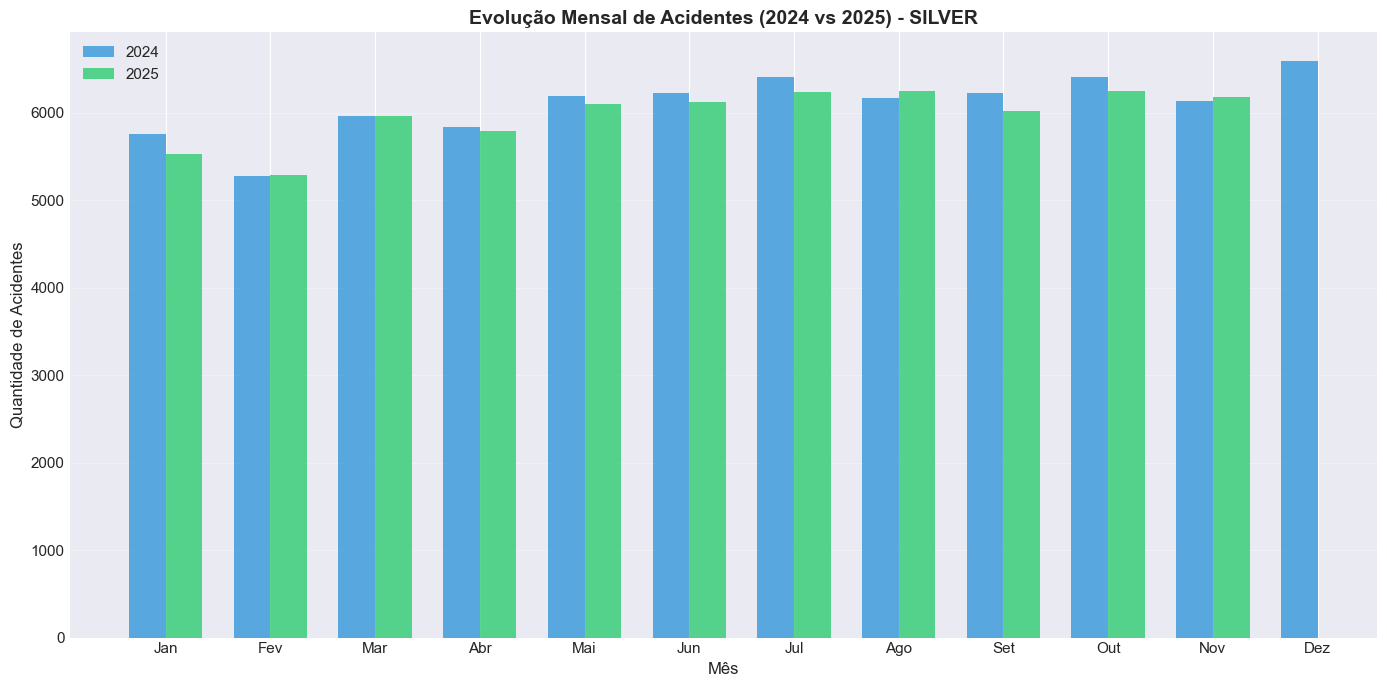

In [ ]:
df['mes'] = pd.to_datetime(df['data_hora']).dt.month
acidentes_mes = df.groupby(['ano_arquivo', 'mes'])['sinistro_id'].nunique().unstack(level=0)

fig, ax = plt.subplots(figsize=(14, 7))
meses = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
x = np.arange(len(meses))
width = 0.35

if 2024 in acidentes_mes.columns:
    valores_2024 = [acidentes_mes[2024].get(i, 0) for i in range(1, 13)]
    ax.bar(x - width/2, valores_2024, width, label='2024', color='#3498db', alpha=0.8)

if 2025 in acidentes_mes.columns:
    valores_2025 = [acidentes_mes[2025].get(i, 0) for i in range(1, 13)]
    ax.bar(x + width/2, valores_2025, width, label='2025', color='#2ecc71', alpha=0.8)

ax.set_xlabel('Mês', fontsize=12)
ax.set_ylabel('Quantidade de Acidentes', fontsize=12)
ax.set_title('Evolução Mensal de Acidentes (2024 vs 2025) - SILVER', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(meses)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## ANÁLISE 2: Distribuição Geográfica (por UF)

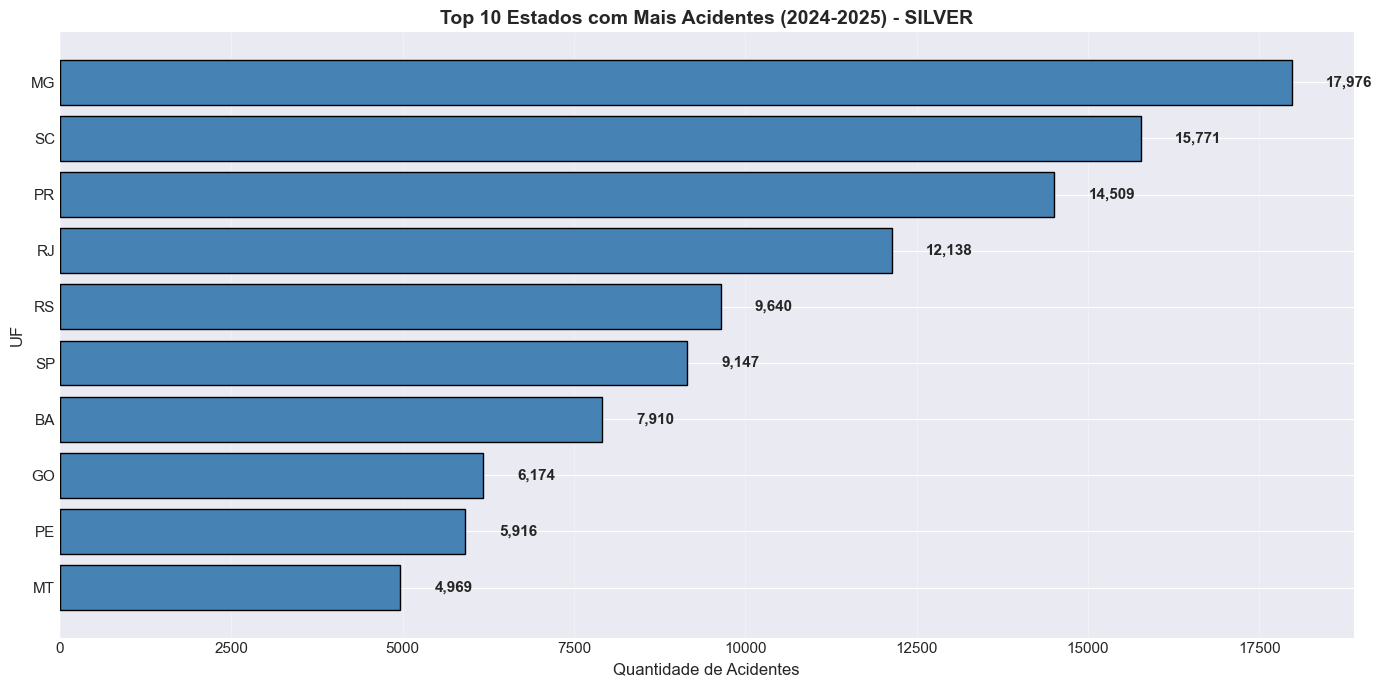

In [ ]:
acidentes_uf = df.groupby('uf')['sinistro_id'].nunique().sort_values(ascending=False).head(10)

plt.figure(figsize=(14, 7))
bars = plt.barh(acidentes_uf.index, acidentes_uf.values, color='steelblue', edgecolor='black')

for i, (uf, valor) in enumerate(acidentes_uf.items()):
    plt.text(valor + 500, i, f'{valor:,}', va='center', fontweight='bold')

plt.title('Top 10 Estados com Mais Acidentes (2024-2025) - SILVER', fontsize=14, fontweight='bold')
plt.xlabel('Quantidade de Acidentes', fontsize=12)
plt.ylabel('UF', fontsize=12)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## ANÁLISE 3: Causas de Acidentes (Top 10)

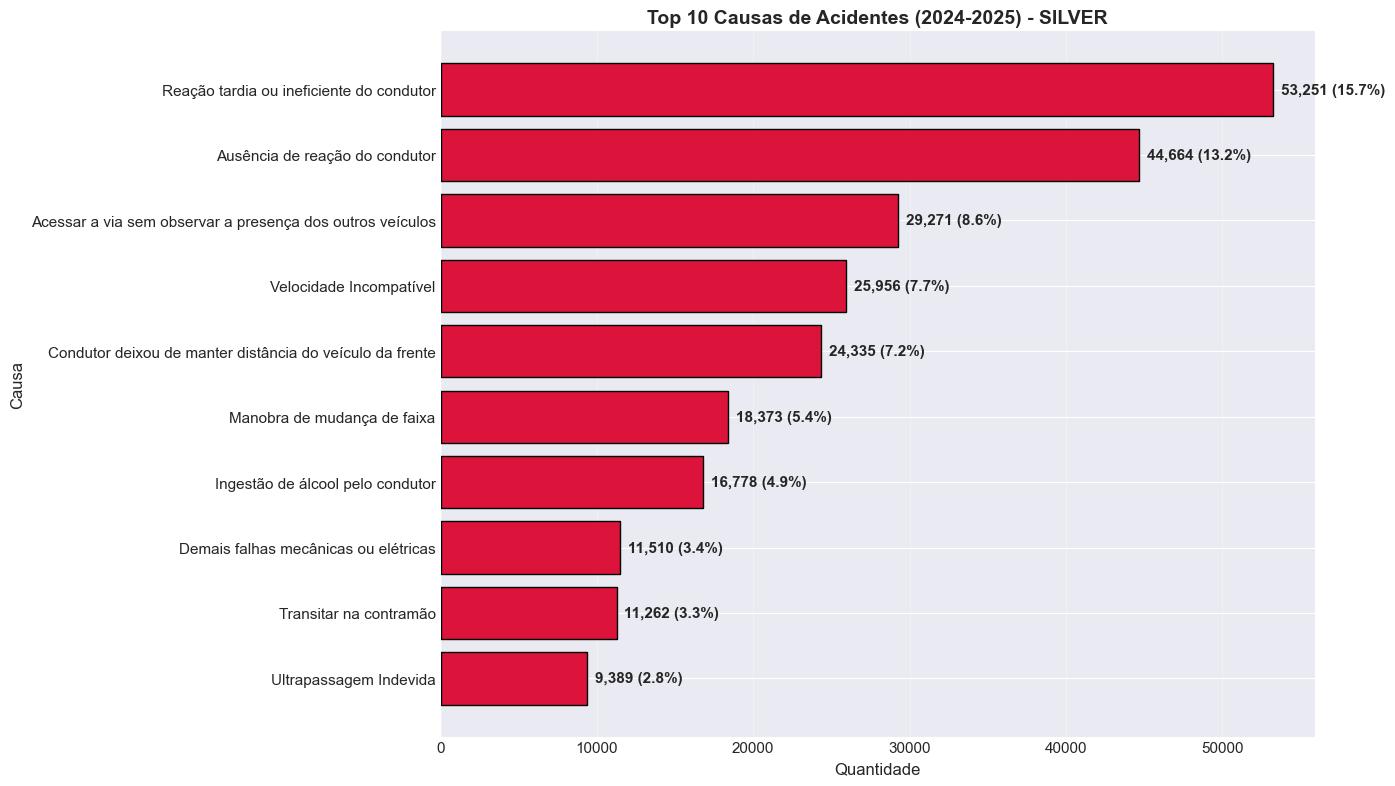

In [ ]:
causas = df['causa_acidente'].value_counts().head(10)

plt.figure(figsize=(14, 8))
bars = plt.barh(range(len(causas)), causas.values, color='crimson', edgecolor='black')
plt.yticks(range(len(causas)), causas.index)

for i, valor in enumerate(causas.values):
    plt.text(valor + 500, i, f'{valor:,} ({(valor/len(df)*100):.1f}%)', 
             va='center', fontweight='bold')

plt.title('Top 10 Causas de Acidentes (2024-2025) - SILVER', fontsize=14, fontweight='bold')
plt.xlabel('Quantidade', fontsize=12)
plt.ylabel('Causa', fontsize=12)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## ANÁLISE 4: Tipos de Acidentes (Top 10)

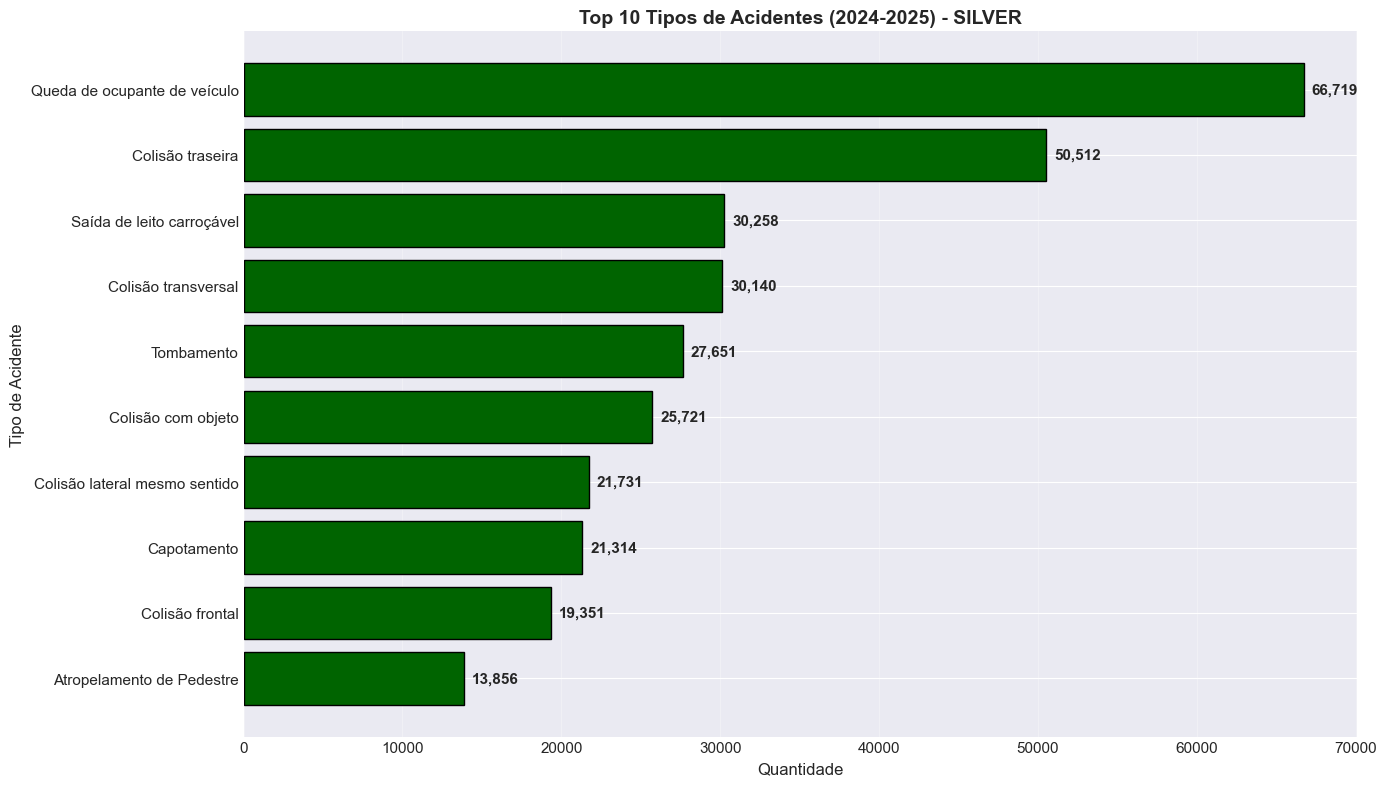

In [ ]:
tipos = df['tipo_acidente'].value_counts().head(10)

plt.figure(figsize=(14, 8))
bars = plt.barh(range(len(tipos)), tipos.values, color='darkgreen', edgecolor='black')
plt.yticks(range(len(tipos)), tipos.index)

for i, valor in enumerate(tipos.values):
    plt.text(valor + 500, i, f'{valor:,}', va='center', fontweight='bold')

plt.title('Top 10 Tipos de Acidentes (2024-2025) - SILVER', fontsize=14, fontweight='bold')
plt.xlabel('Quantidade', fontsize=12)
plt.ylabel('Tipo de Acidente', fontsize=12)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## ANÁLISE 5: Gravidade - Análise de Vítimas

**Nota SILVER:** Estado físico padronizado: `obito`, `grave`, `leve`, `ileso`

Mortos: 11,627 | Feridos Graves: 38,489 | Feridos Leves: 121,415 | Ilesos: 145,518
Total de pessoas envolvidas: 317,049


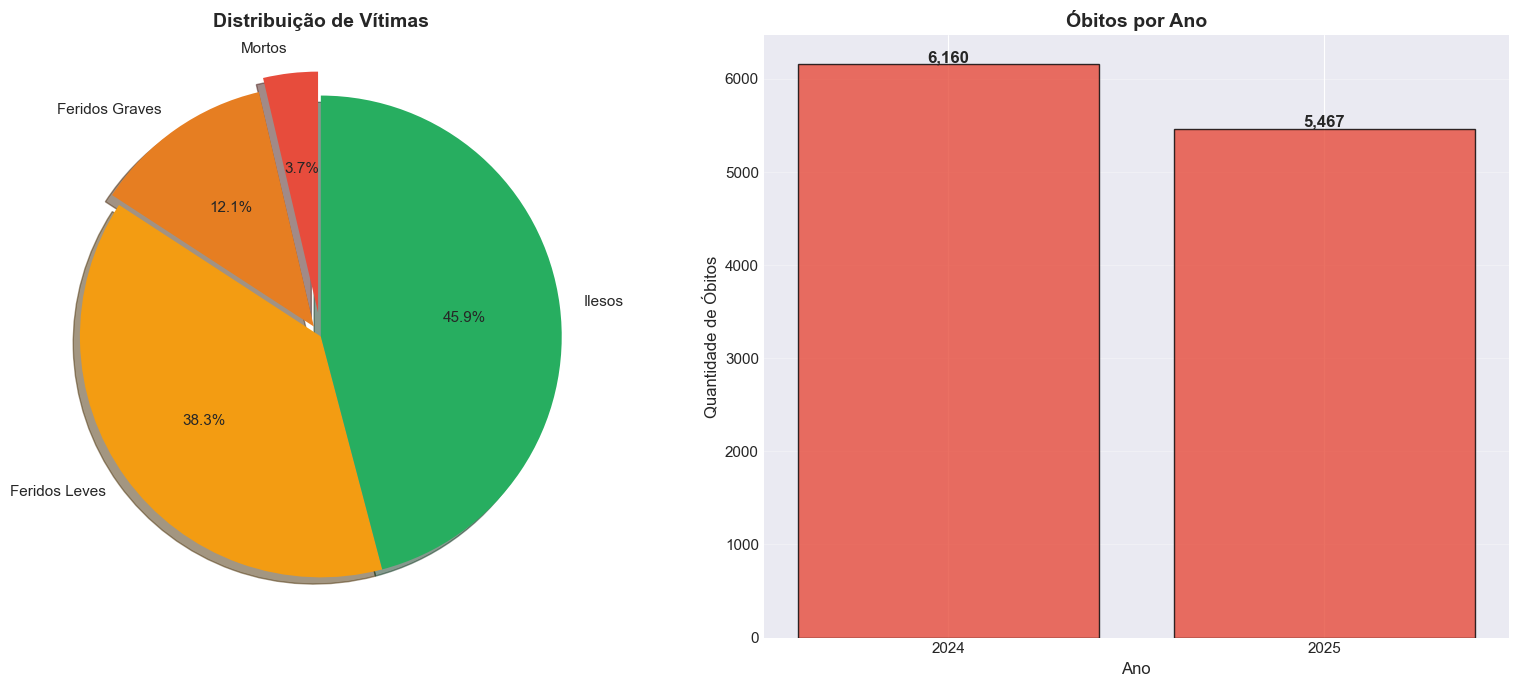

In [ ]:
total_mortos = len(df[df['estado_fisico'] == 'obito'])
total_feridos_graves = len(df[df['estado_fisico'] == 'grave'])
total_feridos_leves = len(df[df['estado_fisico'] == 'leve'])
total_ilesos = len(df[df['estado_fisico'] == 'ileso'])

print(f"Mortos: {total_mortos:,} | Feridos Graves: {total_feridos_graves:,} | Feridos Leves: {total_feridos_leves:,} | Ilesos: {total_ilesos:,}")
print(f"Total de pessoas envolvidas: {total_mortos + total_feridos_graves + total_feridos_leves + total_ilesos:,}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

vitimas_data = [total_mortos, total_feridos_graves, total_feridos_leves, total_ilesos]
vitimas_labels = ['Mortos', 'Feridos Graves', 'Feridos Leves', 'Ilesos']
colors = ['#e74c3c', '#e67e22', '#f39c12', '#27ae60']
explode = (0.1, 0.05, 0, 0)

ax1.pie(vitimas_data, labels=vitimas_labels, autopct='%1.1f%%', startangle=90, 
        colors=colors, explode=explode, shadow=True)
ax1.set_title('Distribuição de Vítimas', fontsize=14, fontweight='bold')

mortos_ano = df[df['estado_fisico'] == 'obito'].groupby('ano_arquivo').size()
ax2.bar(mortos_ano.index.astype(str), mortos_ano.values, 
        color='#e74c3c', edgecolor='black', alpha=0.8)
for i, (ano, valor) in enumerate(mortos_ano.items()):
    ax2.text(i, valor + 20, f'{valor:,}', ha='center', fontweight='bold', fontsize=12)

ax2.set_title('Óbitos por Ano', fontsize=14, fontweight='bold')
ax2.set_xlabel('Ano', fontsize=12)
ax2.set_ylabel('Quantidade de Óbitos', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## ANÁLISE 6: Tipos de Veículos Envolvidos

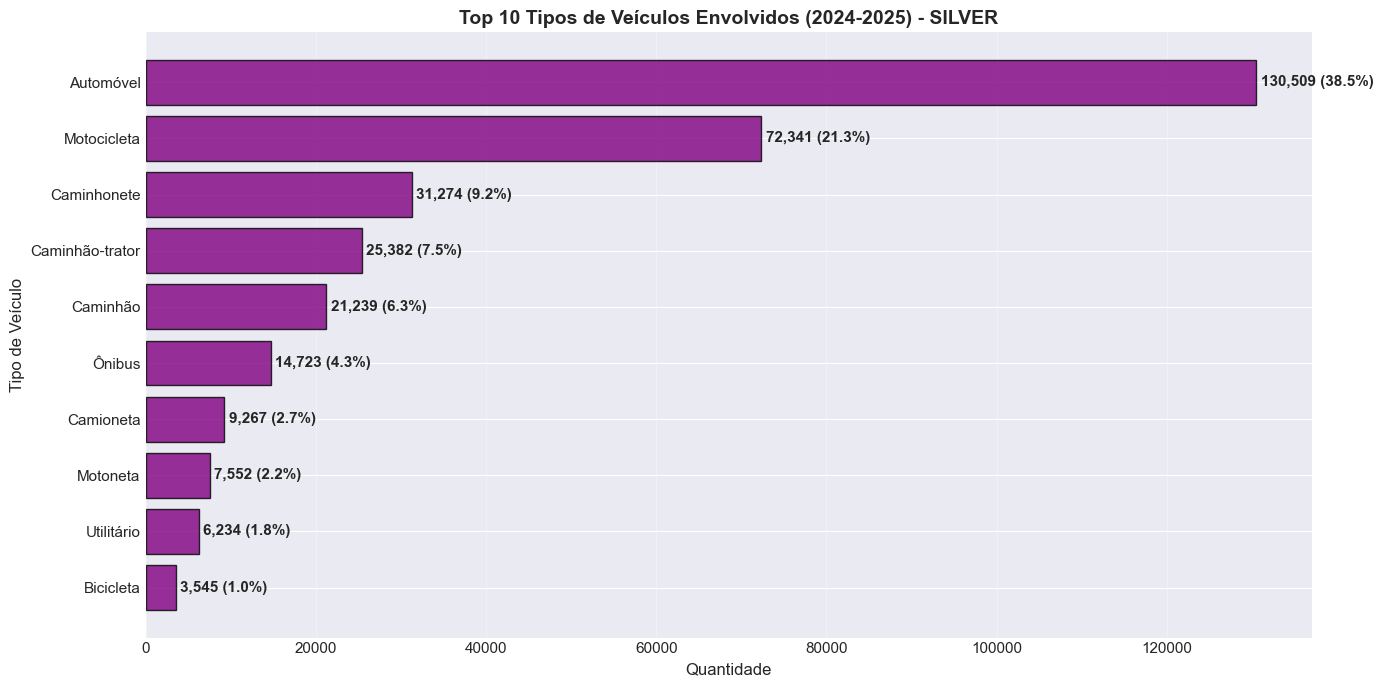

In [ ]:
veiculos = df['tipo_veiculo'].value_counts().head(10)

plt.figure(figsize=(14, 7))
bars = plt.barh(range(len(veiculos)), veiculos.values, 
                color='purple', edgecolor='black', alpha=0.8)
plt.yticks(range(len(veiculos)), veiculos.index)

for i, valor in enumerate(veiculos.values):
    plt.text(valor + 500, i, f'{valor:,} ({(valor/len(df)*100):.1f}%)', 
             va='center', fontweight='bold')

plt.title('Top 10 Tipos de Veículos Envolvidos (2024-2025) - SILVER', 
          fontsize=14, fontweight='bold')
plt.xlabel('Quantidade', fontsize=12)
plt.ylabel('Tipo de Veículo', fontsize=12)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## ANÁLISE 7: Condições Meteorológicas

**Melhoria SILVER:** Valores "Ignorado" foram convertidos para NULL

,Condição Meteorológica,Quantidade,Percentual (%)
0,Céu Claro,216699,63.89
1,Nublado,51602,15.21
2,Chuva,32184,9.49
3,Sol,19079,5.62
4,Garoa/Chuvisco,12176,3.59
5,NÃO INFORMADO,3957,1.17
6,Nevoeiro/Neblina,2973,0.88
7,Vento,506,0.15
8,Granizo,4,0.00
9,Neve,3,0.00


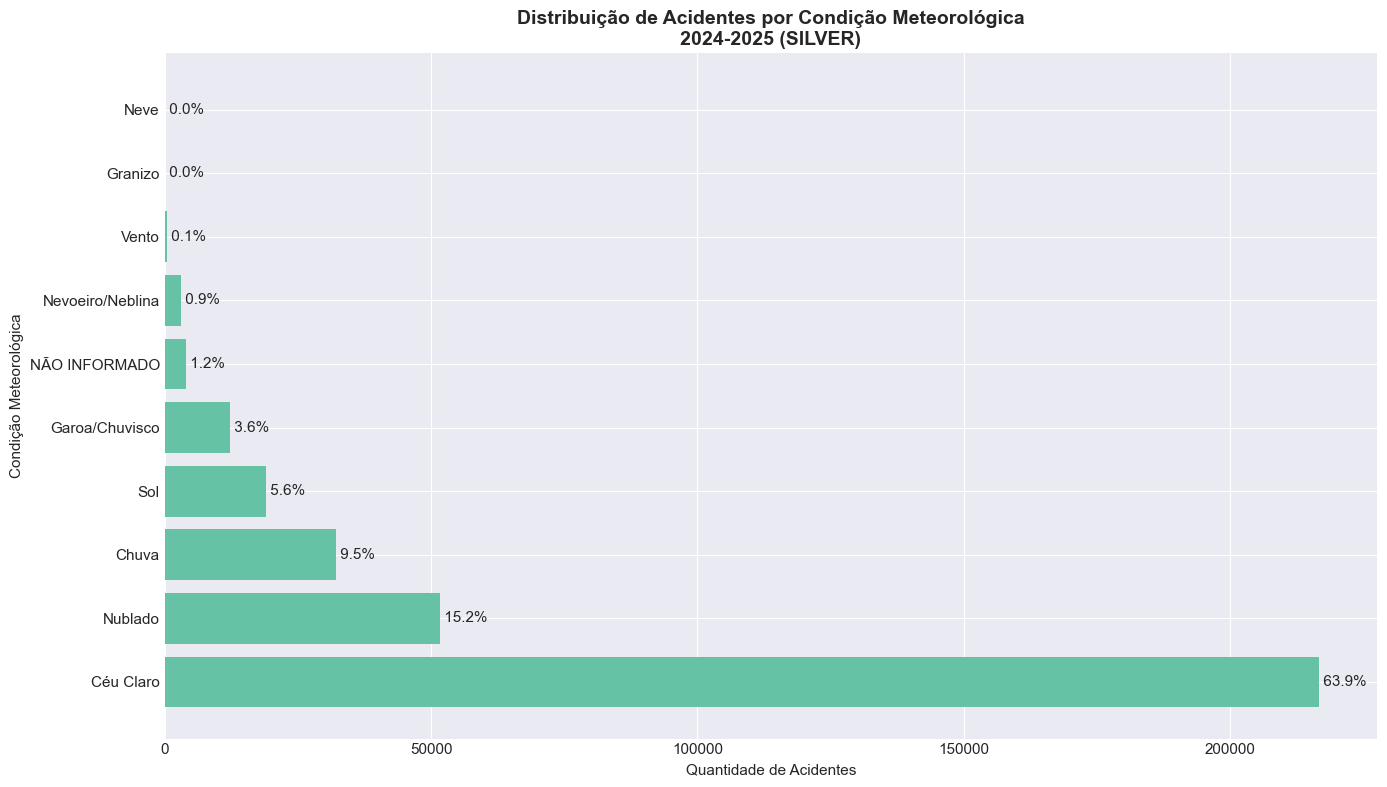

In [ ]:
condicoes = df['condicao_meteorologica'].fillna('NÃO INFORMADO').value_counts()

condicoes_df = pd.DataFrame({
    'Condição Meteorológica': condicoes.index,
    'Quantidade': condicoes.values,
    'Percentual (%)': (condicoes.values / len(df) * 100).round(2)
})

display(condicoes_df)

plt.figure(figsize=(14, 8))
bars = plt.barh(condicoes_df['Condição Meteorológica'], condicoes_df['Quantidade'])

plt.title('Distribuição de Acidentes por Condição Meteorológica\n2024-2025 (SILVER)',
          fontsize=14, fontweight='bold')
plt.xlabel('Quantidade de Acidentes')
plt.ylabel('Condição Meteorológica')

for bar, pct in zip(bars, condicoes_df['Percentual (%)']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f' {pct:.1f}%', va='center')

plt.tight_layout()
plt.show()

## ANÁLISE 8: Matriz de Correlação - Tipo de Acidente vs Gravidade

gravidade,Com Mortos,Com Feridos Graves,Com Feridos Leves,Apenas Ilesos,TOTAL
tipo_acidente,,,,,
Atropelamento de Pedestre,1932,2178,2231,5242,11583
Capotamento,773,2655,10956,5628,20012
Colisão com objeto,788,2586,10258,9965,23597
Colisão frontal,1617,3606,5884,7273,18380
Colisão lateral mesmo sentido,171,1396,6699,12041,20307
Colisão transversal,455,3291,10220,14737,28703
Colisão traseira,527,3496,14777,28989,47789
Queda de ocupante de veículo,2049,10042,28652,21492,62235
Saída de leito carroçável,1445,3405,11613,11847,28310


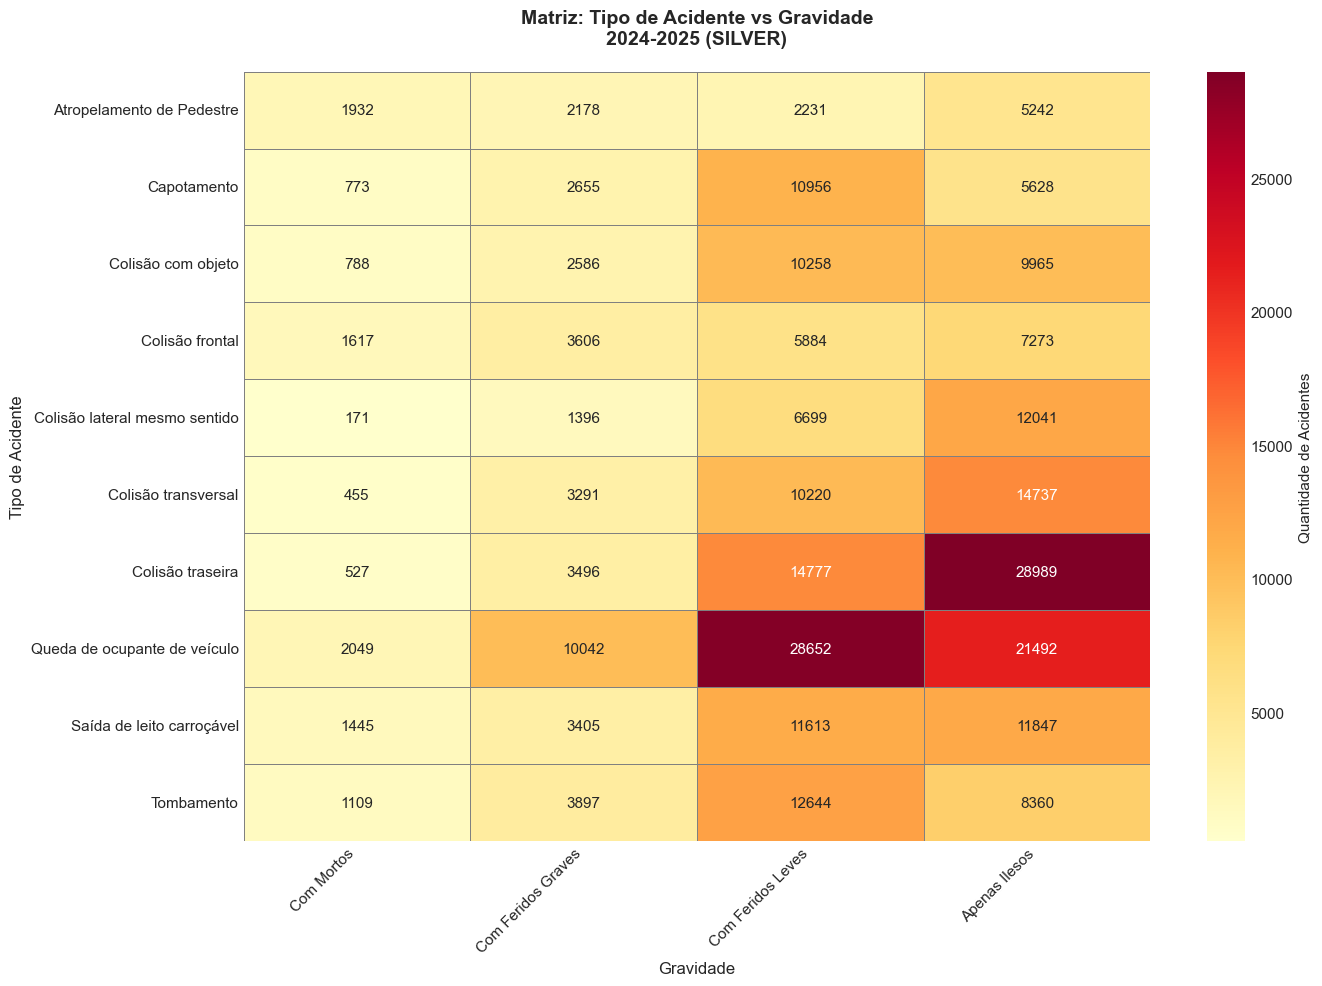

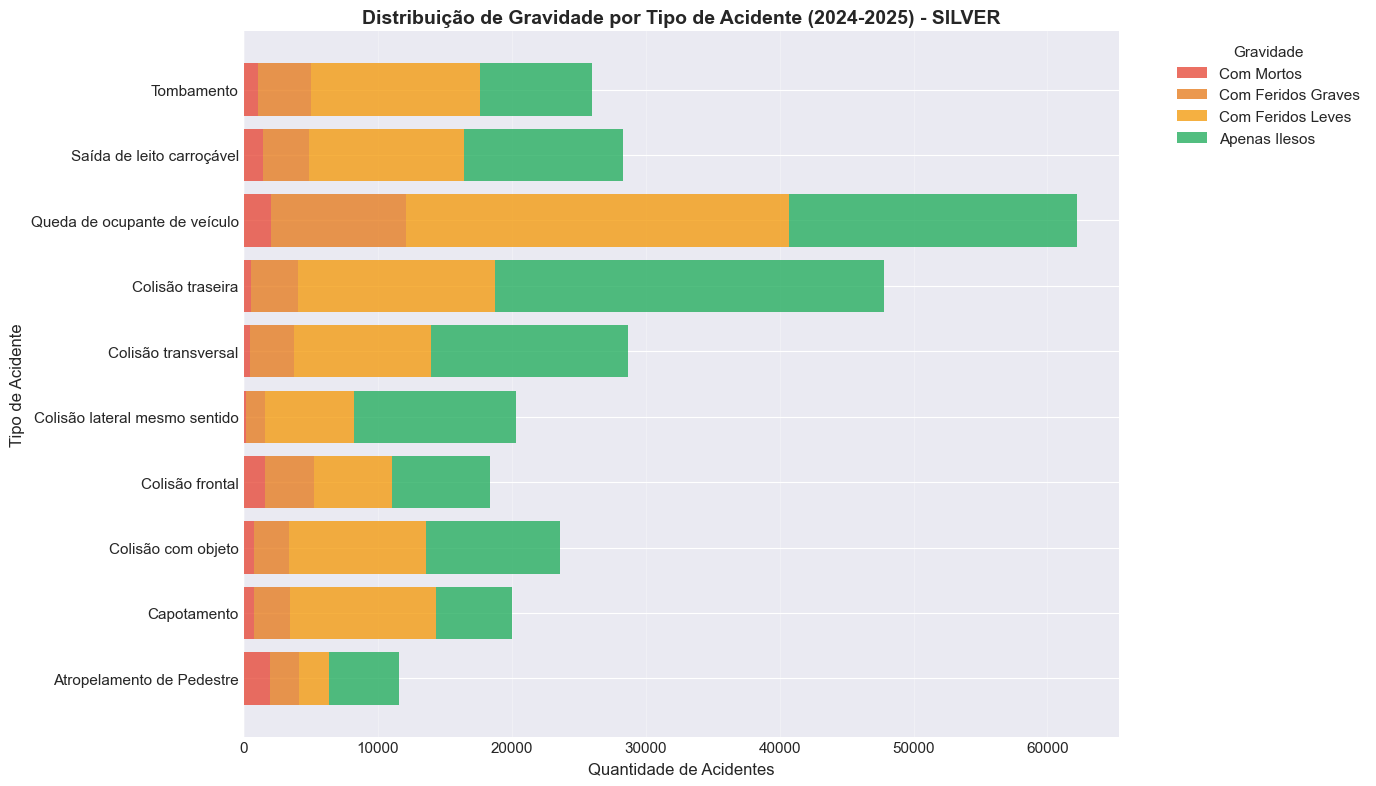

In [ ]:
def classificar_gravidade(row):
    if row == 'obito':
        return 'Com Mortos'
    elif row == 'grave':
        return 'Com Feridos Graves'
    elif row == 'leve':
        return 'Com Feridos Leves'
    elif row == 'ileso':
        return 'Apenas Ilesos'
    else:
        return None

df['gravidade'] = df['estado_fisico'].apply(classificar_gravidade)
top_tipos = df['tipo_acidente'].value_counts().head(10).index
df_matriz = df[df['tipo_acidente'].isin(top_tipos)]

matriz_tipo_gravidade = pd.crosstab(
    df_matriz['tipo_acidente'], 
    df_matriz['gravidade'],
    margins=True,
    margins_name='TOTAL'
)

ordem_colunas = ['Com Mortos', 'Com Feridos Graves', 'Com Feridos Leves', 'Apenas Ilesos']
colunas_existentes = [col for col in ordem_colunas if col in matriz_tipo_gravidade.columns]
outras_colunas = [col for col in matriz_tipo_gravidade.columns 
                  if col not in colunas_existentes and col != 'TOTAL']
colunas_ordenadas = colunas_existentes + outras_colunas
if 'TOTAL' in matriz_tipo_gravidade.columns:
    colunas_ordenadas.append('TOTAL')
matriz_tipo_gravidade = matriz_tipo_gravidade[colunas_ordenadas]

display(matriz_tipo_gravidade)

plt.figure(figsize=(14, 10))
sns.heatmap(matriz_tipo_gravidade.iloc[:-1, :-1], annot=True, fmt='d', 
            cmap='YlOrRd', cbar_kws={'label': 'Quantidade de Acidentes'},
            linewidths=0.5, linecolor='gray')
plt.title('Matriz: Tipo de Acidente vs Gravidade\n2024-2025 (SILVER)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Gravidade', fontsize=12)
plt.ylabel('Tipo de Acidente', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(14, 8))
matriz_plot = matriz_tipo_gravidade.iloc[:-1, :-1]

cores_gravidade = {
    'Com Mortos': '#e74c3c',
    'Com Feridos Graves': '#e67e22', 
    'Com Feridos Leves': '#f39c12',
    'Apenas Ilesos': '#27ae60'
}

bottom = np.zeros(len(matriz_plot))
for col in matriz_plot.columns:
    cor = cores_gravidade.get(col, '#3498db')
    ax.barh(matriz_plot.index, matriz_plot[col], left=bottom, 
            label=col, color=cor, alpha=0.8)
    bottom += matriz_plot[col].values

ax.set_xlabel('Quantidade de Acidentes', fontsize=12)
ax.set_ylabel('Tipo de Acidente', fontsize=12)
ax.set_title('Distribuição de Gravidade por Tipo de Acidente (2024-2025) - SILVER', 
             fontsize=14, fontweight='bold')
ax.legend(title='Gravidade', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## ANÁLISE 9: Heatmap - Distribuição Temporal por UF

,Jan,Fev,Mar,Abr,Mai,Jun,Jul,Ago,Set,Out,Nov,Dez
uf,,,,,,,,,,,,
MG,4283,3124,3891,3410,3711,3681,4513,3913,3679,4081,3893,2478
SC,3225,3126,3099,3267,3302,3083,3461,3115,3209,3335,3371,1718
PR,2952,2703,2911,2986,3235,3083,3331,3197,3230,3131,3223,1746
RJ,2406,2321,2369,2347,2496,2596,2519,2549,2695,2688,2626,1382
RS,2174,2148,2170,2001,1869,2206,2136,2237,2091,1984,1957,1116
SP,1814,1612,1789,1918,1763,1793,1770,1945,1847,2035,2026,939
BA,1995,1403,1688,1909,1765,2001,1898,1785,1717,1860,1672,1147
GO,1374,1080,1269,1200,1348,1378,1486,1348,1235,1299,1118,976
PE,1152,1079,1261,1199,1237,1221,1337,1264,1244,1241,1266,802


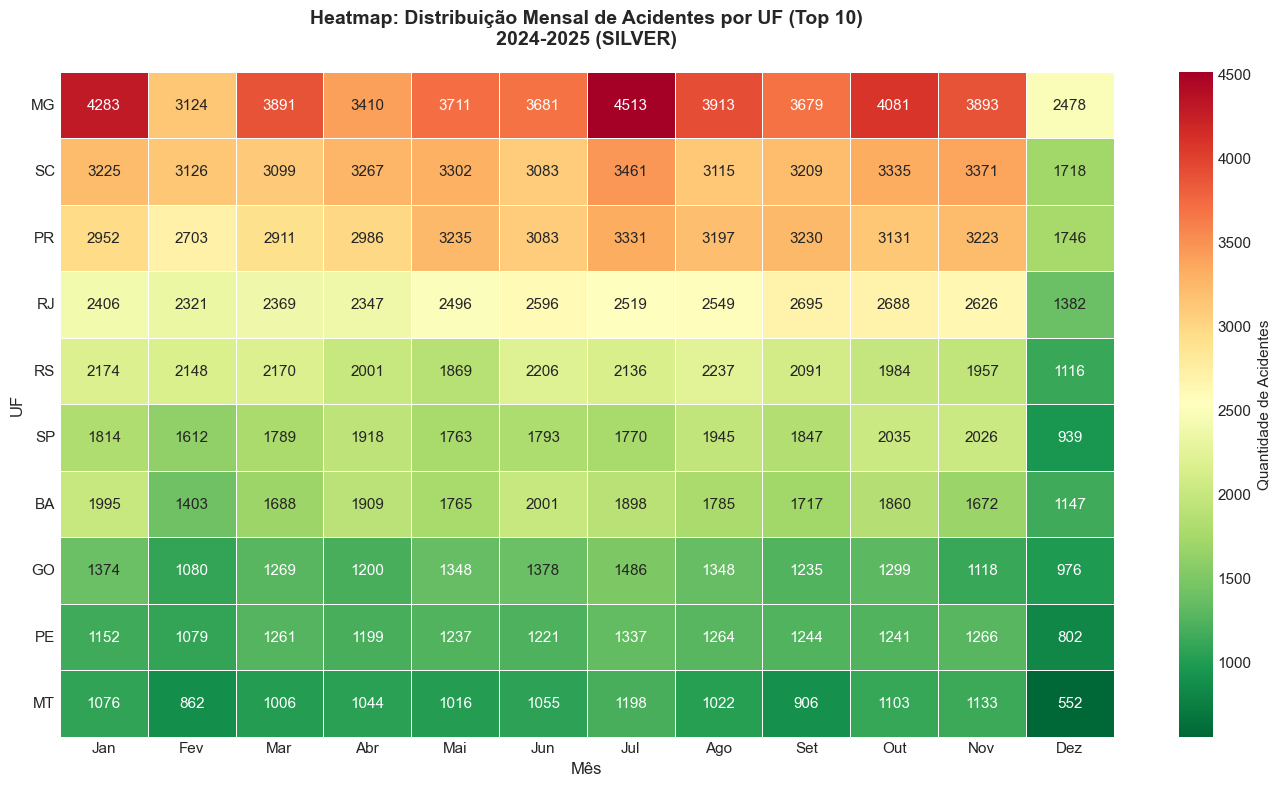

In [ ]:
df['mes'] = pd.to_datetime(df['data_hora']).dt.month

top_10_ufs = df['uf'].value_counts().head(10).index
df_top_ufs = df[df['uf'].isin(top_10_ufs)].copy()

heatmap_uf_mes = pd.crosstab(df_top_ufs['uf'], df_top_ufs['mes'])
heatmap_uf_mes['Total'] = heatmap_uf_mes.sum(axis=1)
heatmap_uf_mes = heatmap_uf_mes.sort_values('Total', ascending=False)
heatmap_uf_mes = heatmap_uf_mes.drop('Total', axis=1)

meses_nomes = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Abr', 5: 'Mai', 6: 'Jun',
               7: 'Jul', 8: 'Ago', 9: 'Set', 10: 'Out', 11: 'Nov', 12: 'Dez'}
heatmap_uf_mes.columns = [meses_nomes.get(col, col) for col in heatmap_uf_mes.columns]

display(heatmap_uf_mes)

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_uf_mes, annot=True, fmt='d', cmap='RdYlGn_r',
            cbar_kws={'label': 'Quantidade de Acidentes'},
            linewidths=0.5, linecolor='white')
plt.title('Heatmap: Distribuição Mensal de Acidentes por UF (Top 10)\n2024-2025 (SILVER)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('UF', fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## ANÁLISE 10: Distribuição de Idade dos Envolvidos

**Diferenças RAW → SILVER:**
- ❌ **RAW:** Valores NA representados como -1, inclui outliers (idades > 200)
- ✅ **SILVER:** Valores NA como NULL, outliers removidos (idade > 120), faixas padronizadas (0-9, 10-19, ..., 100+)

Total de registros: 339,183
Não informados (NULL): 32,474 (9.6%)
Outliers (idade > 200): 0 (removidos no ETL)

  DIFERENÇA DA CAMADA RAW:
   - RAW mantém valores -1 para idade desconhecida e outliers (idade > 200)
   - SILVER: valores -1 → NULL, outliers removidos (>120 anos)

Estatísticas (dados válidos na SILVER):
  Total com faixa etária: 306,709
  Total sem faixa (NULL): 32,474

Distribuição por faixa:
  0-9: 6,039
  10-19: 14,880
  20-29: 69,363
  30-39: 73,196
  40-49: 66,205
  50-59: 42,644
  60-69: 23,853
  70-79: 8,612
  80-89: 1,756
  90-99: 153
  100+: 8


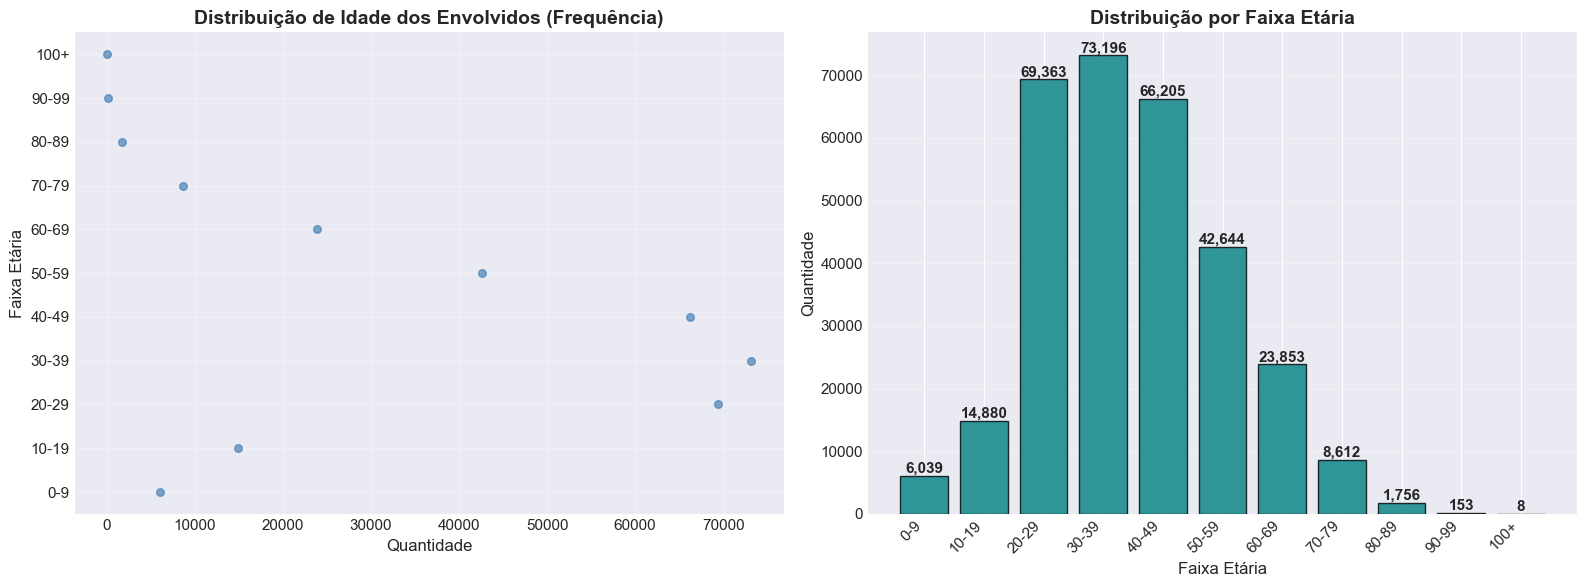

In [ ]:
# Nota: Na SILVER, não temos valores -1 (convertidos para NULL) e outliers foram removidos (idade > 120)

# Função para ordenar numericamente as faixas (ex: '0-9' -> 0, '100+' -> 100) ---
def sort_key_faixa(x):
    try:
        # Pega o primeiro número antes do hífen ou do símbolo +
        return int(x.split('-')[0].replace('+', ''))
    except:
        return 999

# Calcula e ordena usando a chave personalizada
counts_raw = df['faixa_etaria_condutor'].value_counts()
sorted_index = sorted(counts_raw.index, key=sort_key_faixa)
faixa_etaria_condutor_count = counts_raw.reindex(sorted_index)
# --------------------------------------------------------------------------------------------

qtd_nao_informado = df['faixa_etaria_condutor'].isna().sum()

print(f"Total de registros: {len(df):,}")
print(f"Não informados (NULL): {qtd_nao_informado:,} ({qtd_nao_informado/len(df)*100:.1f}%)")
print(f"Outliers (idade > 200): 0 (removidos no ETL)")
print(f"\n  DIFERENÇA DA CAMADA RAW:")
print(f"   - RAW mantém valores -1 para idade desconhecida e outliers (idade > 200)")
print(f"   - SILVER: valores -1 → NULL, outliers removidos (>120 anos)")
print(f"\nEstatísticas (dados válidos na SILVER):")
print(f"  Total com faixa etária: {faixa_etaria_condutor_count.sum():,}")
print(f"  Total sem faixa (NULL): {qtd_nao_informado:,}")

print("\nDistribuição por faixa:")
for faixa, qtd in faixa_etaria_condutor_count.items():
    print(f"  {faixa}: {qtd:,}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Usa a série JÁ ordenada (removemos o .sort_index() que causava o erro)
faixas_ordenadas = faixa_etaria_condutor_count 

ax1.scatter(faixas_ordenadas.values, range(len(faixas_ordenadas)), 
            s=30, alpha=0.7, color='steelblue')
ax1.set_yticks(range(len(faixas_ordenadas)))
ax1.set_yticklabels(faixas_ordenadas.index)
ax1.set_title('Distribuição de Idade dos Envolvidos (Frequência)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Quantidade', fontsize=12)
ax1.set_ylabel('Faixa Etária', fontsize=12)
ax1.ticklabel_format(style='plain', axis='x')
ax1.grid(True, alpha=0.3)

# Usa a mesma série ordenada para o gráfico de barras
faixas_etarias_count = faixa_etaria_condutor_count 
ax2.bar(range(len(faixas_etarias_count)), faixas_etarias_count.values, 
        color='teal', edgecolor='black', alpha=0.8)
ax2.set_xticks(range(len(faixas_etarias_count)))
ax2.set_xticklabels(faixas_etarias_count.index, rotation=45, ha='right')
ax2.set_title('Distribuição por Faixa Etária', fontsize=14, fontweight='bold')
ax2.set_xlabel('Faixa Etária', fontsize=12)
ax2.set_ylabel('Quantidade', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

for i, valor in enumerate(faixas_etarias_count.values):
    ax2.text(i, valor + 500, f'{valor:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## RESUMO EXECUTIVO - SILVER

In [ ]:
print('\n' + '='*80)
print('RESUMO EXECUTIVO - ACIDENTES PRF 2024-2025 (CAMADA SILVER)')
print('='*80)

print(f"\nVOLUME DE DADOS:")
print(f"Registros: {len(df):,} | Acidentes únicos: {df['sinistro_id'].nunique():,}")
print(f"Chaves únicas (sinistro_id, pessoa_id): {df[['sinistro_id', 'pessoa_id']].drop_duplicates().shape[0]:,}")

print(f"\nQUALIDADE DOS DADOS:")
print(f"Duplicatas: {df.duplicated(subset=['sinistro_id', 'pessoa_id']).sum()} (0 esperado)")
print(f"Registros sem chave primária: 0 (removidos no ETL)")
print(f"Outliers de idade (>120): 0 (removidos no ETL)")

obitos = len(df[df['estado_fisico'] == 'obito'])
graves = len(df[df['estado_fisico'] == 'grave'])
leves = len(df[df['estado_fisico'] == 'leve'])
ilesos = len(df[df['estado_fisico'] == 'ileso'])

print(f"\nGRAVIDADE (Estado Físico):")
print(f"Óbitos: {obitos:,} | Feridos Graves: {graves:,} | Feridos Leves: {leves:,} | Ilesos: {ilesos:,}")
print(f"Taxa de fatalidade: {(obitos/len(df)*100):.2f}%")

print(f"\nDESTAQUES:")
print(f"UF com mais acidentes: {acidentes_uf.index[0]} ({acidentes_uf.iloc[0]:,})")
print(f"Causa principal: {causas.index[0]}")
print(f"Tipo principal: {tipos.index[0]}")

print('='*80)


RESUMO EXECUTIVO - ACIDENTES PRF 2024-2025 (CAMADA SILVER)

VOLUME DE DADOS:
Registros: 339,183 | Acidentes únicos: 138,840
Chaves únicas (sinistro_id, pessoa_id): 339,183

QUALIDADE DOS DADOS:
Duplicatas: 0 (0 esperado)
Registros sem chave primária: 0 (removidos no ETL)
Outliers de idade (>120): 0 (removidos no ETL)

GRAVIDADE (Estado Físico):
Óbitos: 11,627 | Feridos Graves: 38,489 | Feridos Leves: 121,415 | Ilesos: 145,518
Taxa de fatalidade: 3.43%

DESTAQUES:
UF com mais acidentes: MG (17,976)
Causa principal: Reação tardia ou ineficiente do condutor
Tipo principal: Queda de ocupante de veículo


## Análise 11: Validação de Integridade: Métricas de Sinistralidade vs. Vítimas

O que está sendo feito:
- Utilizamos a estrutura relacional do banco (chave composta: sinistro_id + pessoa_id) para
- segregar matematicamente o conceito de "Evento" do conceito de "Vítima".
- Validamos se existem duplicatas físicas e comparamos as dimensões.

Por que isso é relevante:
- Na engenharia de dados, garantir a unicidade da chave composta é o que permite calcular
- indicadores de severidade confiáveis. Se tivéssemos duplicatas de pessoas (sujeira),
- a taxa de mortalidade seria calculada errada. Esta etapa valida a qualidade do ETL.

--- INTEGRIDADE DA CAMADA SILVER ---
Total de Registros Carregados: 339,183
Duplicatas de Chave (Sinistro + Pessoa): 0
✅ STATUS: Integridade Relacional Garantida.




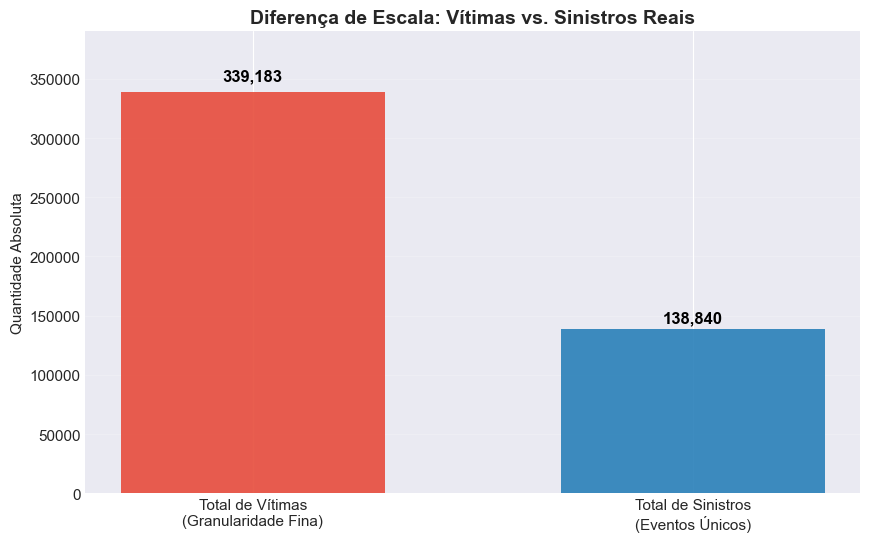

INSIGHT ESTRUTURAL:
A modelagem Silver revela que para cada acidente registrado, temos uma média de 2.44 pessoas envolvidas.
Esta distinção é a base para todos os cálculos de letalidade apresentados a seguir.


In [6]:
# 1. Validação de Unicidade (Constraint Check)
duplicatas_chave = df.duplicated(subset=['sinistro_id', 'pessoa_id']).sum()

print(f"--- INTEGRIDADE DA CAMADA SILVER ---")
print(f"Total de Registros Carregados: {len(df):,}")
print(f"Duplicatas de Chave (Sinistro + Pessoa): {duplicatas_chave}")
if duplicatas_chave == 0:
    print("✅ STATUS: Integridade Relacional Garantida.")
else:
    print("❌ STATUS: Falha de Integridade detectada.")

print("\n" + "="*60 + "\n")

# 2. Visualização Comparativa: O Impacto da Granularidade
# Este gráfico mostra visualmente a diferença entre contar linhas e contar eventos
metricas = {
    'Total de Vítimas\n(Granularidade Fina)': len(df),
    'Total de Sinistros\n(Eventos Únicos)': df['sinistro_id'].nunique()
}

plt.figure(figsize=(10, 6))
colors = ['#e74c3c', '#2980b9'] # Vermelho (Vítimas) e Azul (Eventos)
bars = plt.bar(metricas.keys(), metricas.values(), color=colors, alpha=0.9, width=0.6)

# Adicionar valores nas barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (height*0.02),
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

plt.title('Diferença de Escala: Vítimas vs. Sinistros Reais', fontsize=14, fontweight='bold')
plt.ylabel('Quantidade Absoluta')
plt.ylim(0, max(metricas.values()) * 1.15) # Dá um respiro no topo
plt.grid(axis='y', alpha=0.2)
plt.show()

# Insight Final
razao = metricas['Total de Vítimas\n(Granularidade Fina)'] / metricas['Total de Sinistros\n(Eventos Únicos)']
print(f"INSIGHT ESTRUTURAL:")
print(f"A modelagem Silver revela que para cada acidente registrado, temos uma média de {razao:.2f} pessoas envolvidas.")
print("Esta distinção é a base para todos os cálculos de letalidade apresentados a seguir.")